## What is Continuous Bag of Words (CBOW)?

CBOW is a technique used in Word2Vec to generate word embeddings by predicting the target (center) word based on surrounding context words.

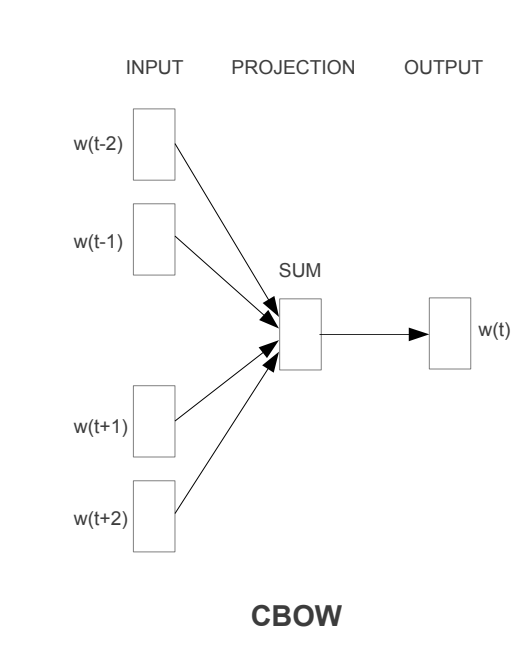

### Key Characteristics

- Used to learn distributed word representations (embeddings).
- Takes context words as input and predicts the target word.
- All input (context) words share the same weight matrix for embedding.
- Embeddings of context words are averaged to form a single projection vector.
- Ignores the order of context words, treating them as a bag of words.



### How it Works

- The model receives a fixed number of words before and after the target word (e.g., 4 previous + 4 next words).
- Each context word is converted into its embedding vector.
- These embeddings are averaged to get a single vector representing the context.
- The averaged vector is used to predict the center word.

Example:

- Input: ["the", "dog"]
- Output: Same as ["dog", "the"] because word order is ignored.



### Why “Bag-of-Words”?

- The model does not preserve the sequence of context words.
- Only the presence and identity of context words are considered.




### Training Objective

- Minimize the loss between the predicted word and the actual center word.
- Typically uses techniques like hierarchical softmax or negative sampling to make training efficient.

### Training Complexity

The training complexity for the CBOW model is given by:

**Q = N × D + D × log₂(V)**

Where:

- **N** = Number of context words (e.g., 8 if using 4 words before and 4 after the target word)
- **D** = Size of the word embedding vector
- **V** = Vocabulary size (total number of unique words in the corpus)







### Explanation:

- **N × D**: Time to compute the average of the context word vectors (each of dimension D)
- **D × log₂(V)**: Time to compute the output layer using hierarchical softmax (or similar approximation techniques)

---

This equation gives an estimate of the **computational cost per training example** in the CBOW model.






Breakdown:

N × D → for averaging the word vectors from context

D × log₂(V) → for computing softmax efficiently using hierarchical softmax

### Implementation

#### Import all the necessary libraries

In [1]:
import numpy as np
from collections import defaultdict
import random


#### Define the corpus

In [3]:
corpus = [
    "the quick brown fox jumped over the lazy dog",
    "i love natural language processing",
    "word embeddings are fun to learn"
]

#### Preprocess the Corpus

In [4]:
# Lowercase and tokenize each sentence into words
tokens = [i.lower().split() for i in corpus]
# Create a sorted set of all unique words in the corpus to form the vocabulary
vocab = sorted(set(word for sentence in tokens for word in sentence))

# Create a mapping from word to a unique index (for numerical processing)
word2idx = {word:idx for idx,word in enumerate(vocab)}
# Create a reverse mapping from index to word (for interpretability)
idx2word ={idx:word for word,idx in word2idx.items()}

# Store the total number of unique words in the vocabulary
vocab_size = len(vocab)

# Print the vocabulary dictionary: word → index
print("Vocabulary:", word2idx)



Vocabulary: {'are': 0, 'brown': 1, 'dog': 2, 'embeddings': 3, 'fox': 4, 'fun': 5, 'i': 6, 'jumped': 7, 'language': 8, 'lazy': 9, 'learn': 10, 'love': 11, 'natural': 12, 'over': 13, 'processing': 14, 'quick': 15, 'the': 16, 'to': 17, 'word': 18}


#### Generate CBOW Training Data

**Input:**  
- `tokens`: List of tokenized sentences (each sentence is a list of words)  
- `window_size`: Number of context words to consider on each side of the target word

**Output:**  
- `X`: Array of context word indices for each training example  
- `Y`: Array of target word indices for each training example

---

**Steps:**

1. Initialize empty lists `X` and `Y` to store context-target pairs.

2. For each sentence in `tokens`:
   - Convert each word in the sentence to its corresponding index using `word2idx`, producing `sentence_ids`.

3. For each word position `i` in `sentence_ids`, starting from `window_size` to `len(sentence_ids) - window_size - 1`:
   - Extract context word indices by concatenating:
     - The `window_size` words before `i`: `sentence_ids[i - window_size : i]`
     - The `window_size` words after `i`: `sentence_ids[i + 1 : i + window_size + 1]`
   - The target word index is the word at position `i`: `sentence_ids[i]`.

4. Append the context indices to `X`.

5. Append the target word index to `Y`.

6. After processing all sentences and positions, convert `X` and `Y` to NumPy arrays.

7. Return `X` and `Y`.


In [5]:
def generate_context_target_pair(tokens, window_size=2):
    """
    Generates context-target pairs for CBOW model training.

    Args:
        tokens (list of list of str): Tokenized corpus, where each sentence is a list of words.
        window_size (int): Number of context words to consider on each side of the target word.

    Returns:
        x (np.ndarray): 2D array of context word indices. Each row contains (2 * window_size) indices.
        y (np.ndarray): 1D array of target word indices (center word).
    """
    x = []  # List to store context word indices
    y = []  # List to store target word indices

    # Iterate over each sentence in the tokenized corpus
    for sentence in tokens:
        # Convert each word in the sentence to its corresponding index
        sentence_idx = [word2idx[word] for word in sentence]

        # Loop through each word where full context is available on both sides
        for i in range(window_size, len(sentence_idx) - window_size):
            # Get context words before and after the target word at position i
            context = sentence_idx[i - window_size:i] + sentence_idx[i + 1:i + window_size + 1]

            # Append context to x
            x.append(context)

            # Append the target word index to y (center word)
            y.append(sentence_idx[i])

    # Convert context and target lists to numpy arrays
    return np.array(x), np.array(y)


In [6]:
X, Y = generate_context_target_pair(tokens, window_size=2)
print("Sample input context (word indices):", X[0])
print("Sample target (word index):", Y[0])

Sample input context (word indices): [16 15  4  7]
Sample target (word index): 1


#### CBOW: Weight Matrices Explanation

**embedding_dim = 10**  
Defines the size of each word vector (hidden layer size)

---

**W1: Word Embedding Matrix**  
Shape: `[vocab_size × embedding_dim]`  
- Each **row** = word in the vocabulary  
- Each **column** = dimension of the word vector

```
       embedding_dim →
       0      1      2      3      4
     `─────────────────────────────────`
    "the" | 0.25 0.10 -0.13 0.44 0.08
    "dog" | 0.02 -0.35 0.50 -0.22 0.14
    "barked" | 0.12 0.18 0.30 0.05 -0.10
    "loudly" | 0.45 -0.20 0.15 0.09 0.33
```

- Each **row** represents a word in the vocabulary.  
- Each **column** is a dimension in the word embedding vector.
---

**W2: Output Projection Matrix**

Assume:
- embedding_dim = 5
- vocab_size = 4

W2 shape: `[embedding_dim × vocab_size]`  
This matrix maps from the embedding space back to vocabulary scores.



```
          vocab (words) →
       "the"   "dog"  "barked"  "loudly"
     ──────────────────────────────────────
0 |   0.15    0.20    -0.25     0.10
1 |  -0.10    0.05     0.30    -0.40
2 |   0.05   -0.15     0.10     0.25
3 |   0.40    0.10    -0.20    -0.15
4 |  -0.05    0.30     0.05     0.20

```

- Each **row** is a dimension in the embedding vector.
- Each **column** corresponds to a word in the vocabulary.








In [7]:
embedding_dim = 10  # size of word vector

# Weight matrices
W1 = np.random.randn(vocab_size, embedding_dim)  # input -> hidden
W2 = np.random.randn(embedding_dim, vocab_size)  # hidden -> output


In [8]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


####Training CBOW Model:


1. For each epoch from 1 to epochs:

   a. Set total loss = 0

   b. For each training example (context, target) in dataset:

      i. Forward pass:
         - Compute hidden layer vector h by averaging embeddings of context words from W1

                  | Word Index | Dim 0 | Dim 1 | Dim 2 |
                  |------------|--------|--------|--------|
                  | 2          | 0.1    | 0.3    | -0.2   |
                  | 5          | 0.4    | -0.1   | 0.2    |
                  | 7          | -0.3   | 0.8    | 0.5    |
                  | 10         | 0.0    | 0.2    | -0.1   |

                  To get **h**, we compute the mean for each dimension:

                  h=((0.1 + 0.4 + (-0.3) + 0.0) / 4)+ ....

                  So **h** is a single vector representing the average context embedding.

                  This average vector **h** summarizes the entire context into one embedding to predict the target word.
        
         - Compute output scores u = h × W2

            Suppose we have:

            h: The averaged context embedding vector (size: embedding_dim)

            W2: The weight matrix projecting from embedding space to vocabulary space
            (size: embedding_dim × vocab_size)

            Example:

            h = [ 0.05, 0.3, 0.1 ] (embedding_dim = 3)

            W2 =

            word1	word2	word3	word4
            dim0	0.2	-0.5	0.3	0.1
            dim1	0.1	0.7	-0.2	-0.4
            dim2	-0.3	0.6	0.1	0.8

            The dot product u = h · W2 gives a vector of raw scores (size: vocab_size = 4):
            u=[(0.05×0.2)+(0.3×0.1)+(0.1×−0.3),(0.05×−0.5)+(0.3×0.7)+(0.1×0.6),(0.05×0.3)+(0.3×−0.2)+(0.1×0.1),(0.05×0.1)+(0.3×−0.4)+(0.1×0.8)]
            Which evaluates approximately to:

            u=[0.05,0.19,−0.04,−0.07]
            Each value corresponds to the score of a vocabulary word being the target word given the context.

         - Apply softmax to u to get predicted probabilities y_pred

      ii. Compute loss:
         - loss += -log(probability assigned to the target word)
            It takes the predicted probability assigned to the correct target word: y_pred[target].

            Applies the negative logarithm: -np.log(...).
            Adds this value to the cumulative loss.

            Why use negative log of predicted probability?

            Cross-entropy loss measures how well the predicted probability distribution matches the true distribution (which is 1 for the correct word, 0 for others).

            Taking negative log penalizes predictions that assign low probability to the correct word:

            If the model predicts a high probability (close to 1) for the correct word, -log(prob) is close to 0 → low loss.

            If the model predicts a low probability for the correct word, -log(prob) is large → high loss.

            This encourages the model during training to assign higher probabilities to the true target words.

      iii. Backward pass:
         - Compute error vector e = y_pred; subtract 1 at index of the target word
              By subtracting 1 at the true class, we measure how far off the prediction is from the true label
         - Compute gradient for W2: dW2 = outer product of h and e
            dW2 = hT * e
                  h0 e0    h0 e1    h0 e2    h0 e3
                  h1 e0    h1 e1    h1 e2    h1 e3
                  h2 e0    h2 e1    h2 e2    h2 e3

            Each element tells you how much to adjust the weight connecting hidden unit \( i \) to output unit \( j \).
            why outer:
              The weight matrix W2 has shape [embedding_dim x vocab_size].
              To update each weight ,W2 (i,j), we need the gradient with respect to that weight.

         - Compute gradient for W1: dW1 = (W2 × e) divided by number of context words
          This vector dW1 represents how much each dimension of the average context embedding contributed to the prediction error, and it’s used to update all the context word embeddings evenly.
          Computes the gradient of the loss with respect to the input embeddings in W1.

          W2 @ e backpropagates the error from the output layer to the embedding layer.

          Since the context was averaged, we divide the gradient by len(context) to evenly distribute the update across all context words.

      iv. Update weights:

         - For each context word index, update W1[word] -= learning_rate × dW1
            Updates the embedding vector for each word in the context window.
            Subtracts a scaled version of the gradient dW1 to move the weights in the direction that reduces loss.
         - Update W2 -= learning_rate × dW2
         - You have 3 context words: "the", "dog", and "barked". Each word has its own vector from the matrix W1. You find their average vector, called h.

          This average vector helps the model predict the center word.

          The model figures out how wrong its prediction is (the loss), and calculates how to fix it (the gradients).

          Since h is the average of the 3 word vectors, you update each of those 3 word vectors by the same amount — this is the gradient for W1.

          For the output weights W2, it connects h to all possible words in the vocabulary at once, so you update the whole W2 matrix using the gradient dW2.

          In short:

          Each context word vector in W1 is updated equally because they all contributed equally.

          The output weight matrix W2 is updated all at once because it influences the prediction for every word.   

   c. Optionally, print loss every 100 epochs

2. Return updated W1 and W2


In [9]:
def train_cbow(X, Y, W1, W2, epochs=1000, learning_rate=0.01):
    """
    Train a Continuous Bag-of-Words (CBOW) model using gradient descent.

    Parameters:
    - X: numpy array of shape (num_samples, 2*window_size), context word indices
    - Y: numpy array of shape (num_samples,), target word indices
    - W1: numpy array of shape (vocab_size, embedding_dim), input embedding matrix
    - W2: numpy array of shape (embedding_dim, vocab_size), output weight matrix
    - epochs: int, number of training iterations over the dataset
    - learning_rate: float, step size for gradient updates

    Returns:
    - Updated W1 and W2 matrices after training
    """
    for epoch in range(epochs):
        loss = 0
        for context, target in zip(X, Y):
            # 1. Forward pass
            # Compute the average embedding vector of the context words
            h = np.mean(W1[context], axis=0)  # shape: (embedding_dim,)

            # Compute raw scores by multiplying hidden vector with output weights
            u = np.dot(h, W2)  # shape: (vocab_size,)

            # Apply softmax to get predicted probability distribution over vocabulary
            y_pred = softmax(u)  # shape: (vocab_size,)

            # 2. Compute loss (cross-entropy for the true target word)
            loss += -np.log(y_pred[target])

            # 3. Backward pass (compute gradients)
            # Gradient of loss w.r.t. output scores (vector of length vocab_size)
            e = y_pred.copy()
            e[target] -= 1  # subtract 1 at true target index (derivative of cross-entropy)

            # Gradient for output weights W2 (embedding_dim x vocab_size)
            dw2 = np.outer(h, e)

            # Gradient for input embeddings W1 (embedding_dim,), averaged over context words
            dw1 = np.dot(W2, e) / len(context)

            # 4. Update weights
            # Update embeddings for each context word in W1
            for word_idx in context:
                W1[word_idx] -= learning_rate * dw1

            # Update output weight matrix W2
            W2 -= learning_rate * dw2

        # Print loss every 100 epochs to monitor training progress
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

    return W1, W2





In [10]:
W1, W2 = train_cbow(X, Y, W1, W2, epochs=1000, learning_rate=0.01)

Epoch 100, Loss: 10.5023
Epoch 200, Loss: 3.8038
Epoch 300, Loss: 1.7410
Epoch 400, Loss: 1.0492
Epoch 500, Loss: 0.7286
Epoch 600, Loss: 0.5482
Epoch 700, Loss: 0.4344
Epoch 800, Loss: 0.3569
Epoch 900, Loss: 0.3012
Epoch 1000, Loss: 0.2594


#### Get Embeddings

In [11]:
def get_word_embedding(word):
    return W1[word2idx[word]]

print("Embedding for 'language':", get_word_embedding("language"))


Embedding for 'language': [ 0.11639344  1.07077018  0.56248837 -0.9649637   0.28437152  1.88839278
  0.36979823 -0.35808638 -0.76528575 -0.94560926]


#### Find Similar Words

In [12]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def most_similar(word, top_n=5):
    target_vec = get_word_embedding(word)
    sims = []

    for other_word in vocab:
        if other_word == word:
            continue
        sim = cosine_similarity(target_vec, get_word_embedding(other_word))
        sims.append((other_word, sim))

    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:top_n]

print("Most similar to 'language':", most_similar("language"))


Most similar to 'language': [('fun', np.float64(0.4481765841472613)), ('are', np.float64(0.43091974986306036)), ('over', np.float64(0.34198613023039526)), ('embeddings', np.float64(0.3146451549807159)), ('love', np.float64(0.3129975667664183))]


## What is Continuous Skip-gram Model?

The Continuous Skip-gram model is a word embedding technique that uses a neural network to learn vector representations of words based on their context. Instead of predicting a target word given its context, like the Continuous Bag of Words (CBOW) model, it predicts surrounding context words given a target word.

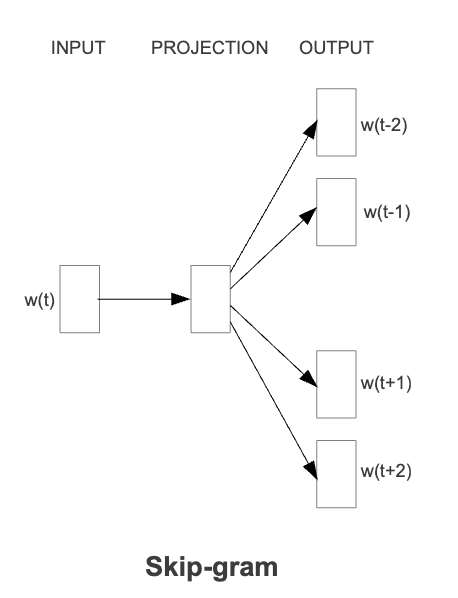



###Key Characteristics

- Used to learn distributed word representations (embeddings).
- Takes a single target word as input and predicts the surrounding context words.
- Each target word is mapped to a vector using a shared weight matrix.
- Tries to maximize the probability of context words given the target word.
- Considers word order implicitly by predicting context words within a window around the target.



###How it Works

- The model receives a target word and predicts multiple context words within a specified window size.
- The target word is converted into its embedding vector.
- This embedding is used to predict each context word independently.
- The model updates embeddings to increase the likelihood of actual context words appearing around the target.

Example:

- Input: "dog"
- Output: Predicts context words like ["the", "barked", "loudly"] within the window.


###Why “Skip-gram”?

- The model “skips” the target word to predict context words.
- Unlike CBOW, it focuses on learning representations that are good at predicting surrounding words.
n uses hierarchical softmax or negative sampling for efficient training.


###Training Objective

- Maximize the probability of correctly predicting context words given the target word.
- Often uses hierarchical softmax or negative sampling for efficient training.


###Implentation

#### Main Differences Between Skip-gram and CBOW Training Functions



##### Input Vector Representation

- **CBOW**:
  - The input vector `h` is the **average of the embeddings** of all context words.
  - Code:
    ```python
    h = np.mean(W1[context], axis=0)
    ```
  - Aggregates information from multiple context words before making a prediction.

- **Skip-gram**:
  - The input vector `h` is the **embedding of the single target word**.
  - Code:
    ```python
    h = W1[target]
    ```
  - Tries to predict multiple context words independently from one target word embedding.



##### Embedding Updates

- **CBOW**:
  - Updates the **embeddings of all context words evenly**.
  - Code:
    ```python
    for word_idx in context:
        W1[word_idx] -= learning_rate * dw1
    ```
  - Gradient is **distributed equally** back to each context word's embedding.

- **Skip-gram**:
  - Updates **only the embedding of the target word**.
  - Code:
    ```python
    W1[target] -= learning_rate * dw1
    ```
  - Only the target embedding is updated per iteration.






#### Loss Computation

- **CBOW**:
  - Computes the loss **once per target word** using the averaged context.

- **Skip-gram**:
  - Computes the loss and gradients **once per predicted context word** inside an inner loop.





##### Summary

- **Skip-gram**: Models the relationship of a **target word predicting each context word individually**.
- **CBOW**: **Summarizes context words first**, then predicts the target word.


####Generate skip-gram Training Data

In [13]:
def generate_skipgram_pairs(tokens, window_size=2):
    """
    Generates (target, context) pairs for Skip-gram model training.

    Args:
        tokens (list of list of str): Tokenized corpus.
        window_size (int): Number of context words on each side.

    Returns:
        x (np.ndarray): 1D array of target word indices.
        y (list of lists): Each inner list contains context word indices for the corresponding target.
    """
    x = []  # target words
    y = []  # context words per target

    for sentence in tokens:
        sentence_idx = [word2idx[word] for word in sentence]
        for i in range(window_size, len(sentence_idx) - window_size):
            target = sentence_idx[i]
            context = sentence_idx[i - window_size:i] + sentence_idx[i + 1:i + window_size + 1]

            x.append(target)
            y.append(context)

    return np.array(x), y


In [14]:
X, Y = generate_skipgram_pairs(tokens, window_size=2)
print("Sample input context (word indices):", X[0])
print("Sample target (word index):", Y[0])

Sample input context (word indices): 1
Sample target (word index): [16, 15, 4, 7]


#### Training Model

In [15]:
def train_skipgram(X, Y, W1, W2, epochs=1000, learning_rate=0.01):
    """
    Train a Skip-gram model.

    Parameters:
    - X: numpy array of target word indices (shape: num_samples,)
    - Y: list of lists of context word indices (length: num_samples)
    - W1: numpy array (vocab_size x embedding_dim) input embedding matrix
    - W2: numpy array (embedding_dim x vocab_size) output weight matrix
    - epochs: int, training iterations
    - learning_rate: float

    Returns:
    - Updated W1, W2 matrices
    """
    for epoch in range(epochs):
        loss = 0
        for target, context_list in zip(X, Y):
            h = W1[target]  # embedding vector for target word

            for context_word in context_list:
                u = np.dot(h, W2)  # raw scores for all vocab
                y_pred = softmax(u)
                loss += -np.log(y_pred[context_word])

                e = y_pred.copy()
                e[context_word] -= 1

                dw2 = np.outer(h, e)
                dw1 = np.dot(W2, e)

                W1[target] -= learning_rate * dw1
                W2 -= learning_rate * dw2

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

    return W1, W2


In [16]:
W1, W2 = train_skipgram(X, Y, W1, W2, epochs=1000, learning_rate=0.01)

Epoch 100, Loss: 49.3266
Epoch 200, Loss: 47.6850
Epoch 300, Loss: 47.3521
Epoch 400, Loss: 47.2143
Epoch 500, Loss: 47.1333
Epoch 600, Loss: 47.0748
Epoch 700, Loss: 47.0269
Epoch 800, Loss: 46.9847
Epoch 900, Loss: 46.9459
Epoch 1000, Loss: 46.9095


In [17]:
print("Embedding for 'language':", get_word_embedding("language"))

Embedding for 'language': [ 0.11639344  1.07077018  0.56248837 -0.9649637   0.28437152  1.88839278
  0.36979823 -0.35808638 -0.76528575 -0.94560926]


In [18]:
print("Most similar to 'language':", most_similar("language"))


Most similar to 'language': [('embeddings', np.float64(0.3146451549807159)), ('love', np.float64(0.3129975667664183)), ('brown', np.float64(0.2759727635111502)), ('fun', np.float64(0.1990721412429139)), ('jumped', np.float64(0.1911121012908123))]
